In [5]:
from qiskit.aqua.algorithms import VQE, NumPyEigensolver
import matplotlib.pyplot as plt
import numpy as np
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
from qiskit.aqua.operators import Z2Symmetries
from qiskit import IBMQ, BasicAer, Aer
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry import FermionicOperator
from qiskit.aqua import QuantumInstance
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [6]:
def get_qubit_op(dist):
    driver = PySCFDriver(atom="Li .0 .0 .0; H .0 .0 " + str(dist), unit=UnitsType.ANGSTROM, 
                         charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    freeze_list = [0]
    remove_list = [-3, -2]
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    remove_list = [x % molecule.num_orbitals for x in remove_list]
    freeze_list = [x % molecule.num_orbitals for x in freeze_list]
    remove_list = [x - len(freeze_list) for x in remove_list]
    remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
    freeze_list += [x + molecule.num_orbitals for x in freeze_list]
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
    num_spin_orbitals -= len(freeze_list)
    num_particles -= len(freeze_list)
    ferOp = ferOp.fermion_mode_elimination(remove_list)
    num_spin_orbitals -= len(remove_list)
    qubitOp = ferOp.mapping(map_type='parity', threshold=0.00000001)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
    shift = energy_shift + repulsion_energy
    return qubitOp, num_particles, num_spin_orbitals, shift

In [7]:
backend = BasicAer.get_backend("statevector_simulator")
distances = np.arange(0.5, 4.0, 0.1)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=5)
for dist in distances:
    qubitOp, num_particles, num_spin_orbitals, shift = get_qubit_op(dist)
    result = NumPyEigensolver(qubitOp).run()
    exact_energies.append(np.real(result.eigenvalues) + shift)
    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        qubit_mapping='parity'
    ) 
    var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=initial_state,
        qubit_mapping='parity'
    )
    vqe = VQE(qubitOp, var_form, optimizer)
    vqe_result = np.real(vqe.run(backend)['eigenvalue'] + shift)
    vqe_energies.append(vqe_result)
    print("Interatomic Distance:", np.round(dist, 2), "VQE Result:", vqe_result, "Exact Energy:", exact_energies[-1])
    
print("All energies have been calculated")

Interatomic Distance: 0.5 VQE Result: -7.039673440923151 Exact Energy: [-7.03973252]
Interatomic Distance: 0.6 VQE Result: -7.313308879951078 Exact Energy: [-7.31334583]
Interatomic Distance: 0.7 VQE Result: -7.50088703552862 Exact Energy: [-7.50092209]
Interatomic Distance: 0.8 VQE Result: -7.630945410037183 Exact Energy: [-7.63097825]
Interatomic Distance: 0.9 VQE Result: -7.720781099404058 Exact Energy: [-7.72081241]
Interatomic Distance: 1.0 VQE Result: -7.782211599758002 Exact Energy: [-7.7822424]
Interatomic Distance: 1.1 VQE Result: -7.823568082044984 Exact Energy: [-7.82359928]
Interatomic Distance: 1.2 VQE Result: -7.8506661327139895 Exact Energy: [-7.85069838]
Interatomic Distance: 1.3 VQE Result: -7.867529586222178 Exact Energy: [-7.86756329]
Interatomic Distance: 1.4 VQE Result: -7.876966254482491 Exact Energy: [-7.87700149]
Interatomic Distance: 1.5 VQE Result: -7.880979506435381 Exact Energy: [-7.88101572]
Interatomic Distance: 1.6 VQE Result: -7.881036617368813 Exact Ene

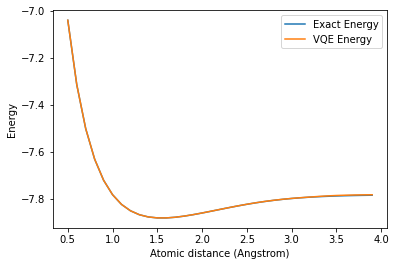

In [8]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()

In [9]:
driver = PySCFDriver(atom='H .0 .0 -0.3625; H .0 .0 0.3625', unit=UnitsType.ANGSTROM, charge=0, spin=0, basis='sto3g')
molecule = driver.run()
num_particles = molecule.num_alpha + molecule.num_beta
qubitOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals).mapping(map_type='parity')
qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)

In [10]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibmq_lima")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())
quantum_instance = QuantumInstance(backend=backend, 
                                   shots=8192, 
                                   noise_model=noise_model, 
                                   coupling_map=coupling_map,
                                   measurement_error_mitigation_cls=CompleteMeasFitter,
                                   cals_matrix_refresh_period=30)

/tmp/ipykernel_98/1773007009.py:6: DeprecationWarning: Passing BackendProperties instead of a "backend" object has been deprecated as of qiskit-aer 0.10.0 and will be removed no earlier than 3 months from that release date. Duration dependent delay relaxation noise requires a backend object.
  noise_model = NoiseModel.from_backend(device.properties())


In [11]:
exact_solution = NumPyEigensolver(qubitOp).run()
print("Exact Result:", np.real(exact_solution.eigenvalues) + molecule.nuclear_repulsion_energy)
optimizer = SPSA(maxiter=100)
var_form = EfficientSU2(qubitOp.num_qubits, entanglement="linear")
vqe = VQE(qubitOp, var_form, optimizer=optimizer)
ret = vqe.run(quantum_instance)
vqe_result = np.real(ret['eigenvalue']+ molecule.nuclear_repulsion_energy)
print("VQE Result:", vqe_result)

Exact Result: [-1.13722138]
VQE Result: -1.104858566439199
